# Multinomial logistic regression model : training and prediction
This notebook contains the implementation of a multinomial logistic regression model for the classification of the ImageNet dataset. The model is trained with custom dataset constructed with penultimate layer outputs from ResNet-50 evaluation (Cf. [Penultimate layer outputs saving](./penultimate_layer_outputs_saving.ipynb) notebook). Training is conducted for different values of weight decay in order to study its impact on the learning of the classes.

## Import
This cell imports the required modules for this notebook.

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
from torchinfo import summary

import pandas as pd
import numpy as np

import json
import os
import string

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

## Classes

#### Custom dataset

In [7]:
class PenultimateOutputsDataset(Dataset):
    def __init__(self, folder_path, device='cpu'):

        if os.path.exists(f'{folder_path}/penultimate_layer_outputs') == False:
            raise ValueError(f'{folder_path}/penultimate_layer_outputs does not exist')
        
        with open(f'{folder_path}/penultimate_layer_outputs/data.json') as data:
            self.data_tensors = json.load(data)

        self.file_list = [f'{folder_path}/penultimate_layer_outputs/penultimate_layer_outputs_{index}.pt' for index in range(self.data_tensors['last_file_indice']+1)]
        self.labels = torch.load(f'{folder_path}/penultimate_layer_labels.pt', map_location=device)
        self.length = self.data_tensors['min_size_segmentation']*self.data_tensors['last_file_indice']+torch.load(f'{folder_path}/penultimate_layer_outputs/penultimate_layer_outputs_{self.data_tensors["last_file_indice"]}.pt', map_location=device).shape[0]
        self.device = device
        self.data_cache = None
        
    def __len__(self):
        return self.length

    def __getitem__(self, index):

        if index < 0 or index >= self.length :
           raise ValueError(f'Index need to be between 0 and {self.length-1}')
        
        index_file = index//self.data_tensors['min_size_segmentation']
        index_in_file = index%self.data_tensors['min_size_segmentation']

        if (self.data_cache is None) or self.data_cache[0] != index_file :
            file = self.file_list[index_file]
            tensors = torch.load(file, map_location=self.device)
            self.data_cache = (index_file, tensors)
            
        tensor = self.data_cache[1][index_in_file]
        label = self.labels[index]
        return tensor, label


#### LogisticRegression model

In [8]:
torch.manual_seed(0) # Experiment reproducibility

class LogisticRegression(nn.Module): 
    def __init__(self, input_size, num_classes): 
        super(LogisticRegression, self).__init__() 
        self.linear = nn.Linear(input_size, num_classes) 
  
    def forward(self, x): 
        out = self.linear(x) 
        return out 
        
    def load_weights(self, weights) :
        self.load_state_dict(weights)

## Set up hyperparameters for training

In [9]:
split = "train"
outputs_folder = f"../data/saved_outputs/{split}"
if not os.path.exists(outputs_folder):
    raise ValueError(f'{outputs_folder} does not exist')

common_subfolders_name = "_weight_decay_"
models_folder = "../data/saved_models/various_weight_decay_models"

if not os.path.exists(models_folder):
    os.makedirs(models_folder)
    
input_size = 2048
num_classes = 1000

batch_size = 256
num_epochs = 90

# initialize the weight decay parameters
num_weight_decay = 11
weight_decay_parameters = torch.cat((torch.tensor([0]), (torch.logspace(-7,-2, num_weight_decay))), dim=0)

# optimizer parameters
learning_rate = 0.1
momentum = 0.9

# scheduler parameters
lr_decay_step = 30
decay_rate = 0.1



## Initialization 

In [10]:
# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# dataset initialization
dataset = PenultimateOutputsDataset(outputs_folder)
print(f"Dataset length: {len(dataset)}")

# dataloader initialization
train_loader = DataLoader(dataset, batch_size=batch_size, pin_memory=True)

Dataset length: 1281167


## Training

In [ ]:
# model training for each weight decay parameter
for training_index, weight_decay_parameter in enumerate(weight_decay_parameters) :

    print(f"Processing step {training_index+1}/{len(weight_decay_parameters)}, weight decay = {weight_decay_parameter:.3e}.")
    
    # model initialization
    model = LogisticRegression(input_size=input_size, num_classes=num_classes) 
    model = model.to(DEVICE)

    # loss function, optimizer and scheduler initialization
    loss_function = nn.CrossEntropyLoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay_parameter)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=decay_rate)

    # create the folder to save the model
    folder_path = os.path.join(models_folder, f"{training_index+1}{common_subfolders_name}{weight_decay_parameter:.3e}")
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # initialization of the history  
    accuracy_history = []
    loss_history = torch.tensor([]).to(DEVICE) 
    L2_regularization_history = torch.tensor([]).to(DEVICE) 
    mean_loss_class = torch.tensor([]).to(DEVICE) 
    weights_epoch = torch.tensor([]).to(DEVICE) 

    # get the number of images for each class
    nb_image_class = torch.bincount(dataset.labels).to(DEVICE)
    
    for epoch in range(num_epochs): 

        # create the subfolders to save the models during the training and the data
        models_path = os.path.join(folder_path, "models")
        data_path = os.path.join(folder_path, "train_data")
        if not os.path.exists(models_path):
            os.makedirs(models_path)
        if not os.path.exists(data_path):
            os.makedirs(data_path)
            
        # initialisation of the number of correct predictions
        correct_predictions = 0
    
        # initialisation of the class loss
        class_loss = torch.zeros(1000, device=DEVICE)
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]"):
            
            # move tensors to the configured device
            inputs = inputs.to(DEVICE) 
            labels = labels.to(DEVICE)
            
            # Forward pass 
            outputs = model(inputs) 
            loss = loss_function(outputs, labels)
            L2_regularization = loss + weight_decay_parameter * sum(t.pow(2).sum() for t in model.state_dict().values()) / 2
    
            # process error for each class
            input_loss = nn.functional.cross_entropy(outputs,labels,reduction='none')
            class_loss.index_add_(0,labels,input_loss)
            
            # get the predicted class for each inputs and update the number of correct predictions
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
    
            # Backward and optimize 
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step()
        
        # update the learning rate
        scheduler.step()
    
        # save the model at the end of each epoch
        torch.save(model.state_dict(), f'{models_path}/epoch-{epoch}.pt')
    
        # compute the accuracy
        accuracy = 100 * correct_predictions / len(dataset)
    
        # concatenate the results
        accuracy_history.append(accuracy)
        loss_history = torch.cat((loss_history, loss.unsqueeze(0)), dim=0)
        L2_regularization_history = torch.cat((L2_regularization_history, L2_regularization.unsqueeze(0)), dim=0)
        mean_loss_class = torch.cat((mean_loss_class, (class_loss/nb_image_class).detach().unsqueeze(0)), dim=0)
        weights_epoch = torch.cat((weights_epoch, sum(t.abs().sum() for t in model.state_dict().values()).unsqueeze(0)), dim=0)
        
        # print the results
        print(f'>> Accuracy: {accuracy} %\n-- Loss: {loss.item()}\n-- Complete optimized function value: {L2_regularization.item()}')
            
    # save the history
    torch.save(accuracy_history, f'{data_path}/accuracy.pt')
    torch.save(loss_history, f'{data_path}/loss.pt')
    torch.save(L2_regularization_history, f'{data_path}/L2_regularization.pt')
    torch.save(mean_loss_class, f'{data_path}/mean_loss_class.pt')
    torch.save(weights_epoch, f'{data_path}/weights.pt')

    print(f"Step {training_index+1}/{len(weight_decay_parameters)} completed.")

## Evaluation

In [ ]:
# model evaluation for each weight decay parameter and each epoch of the training
for training_index, weight_decay_parameter in enumerate(weight_decay_parameters) :

    print(f"Processing step {training_index+1}/{len(weight_decay_parameters)}, weight decay = {weight_decay_parameter:.3e}.")
    
    # model initialization
    model = LogisticRegression(input_size=input_size, num_classes=num_classes)
    model = model.to(DEVICE)

    # loss function initialization
    loss_function = nn.CrossEntropyLoss() 

    # create the folder to save the model
    folder_path = os.path.join(models_folder, f"{training_index+1 if (training_index+1) <=9 else list(string.ascii_lowercase)[(training_index+1)%10]}{common_subfolders_name}{weight_decay_parameter:.3e}")
    
    # initialization of the history
    accuracy_history = []
    loss_history = torch.tensor([]).to(DEVICE) 
    mean_loss_class = torch.tensor([]).to(DEVICE)
    mean_loss_class2 = torch.tensor([]).to(DEVICE)
    weights_epoch = torch.tensor([]).to(DEVICE)
    last_outputs = torch.tensor([]).to(DEVICE)

    # get the number of images for each class
    nb_image_class = torch.bincount(dataset.labels).to(DEVICE)
    
    for epoch in range(num_epochs-1,num_epochs): 

        # create the subfolders to load the models saved during the training and save the data of the test
        models_path = os.path.join(folder_path, "models")
        data_path = os.path.join(folder_path, "test_data")
        if not os.path.exists(data_path):
            os.makedirs(data_path)
            
        # load the model for the epoch
        model.load_weights(torch.load(f'{models_path}/epoch-{epoch}.pt', map_location=DEVICE))

        # initialize the number of correct predictions
        correct_predictions = 0
    
        # initialize the class loss
        class_loss = torch.zeros(1000, device=DEVICE)
        
        model.eval()
        with torch.no_grad():
        
            for inputs, labels in tqdm(train_loader):
                
                # move tensors to the configured device
                inputs = inputs.to(DEVICE) 
                labels = labels.to(DEVICE)

                # Forward pass 
                outputs = model(inputs) 
                loss = loss_function(outputs, labels)
        
                # process error for each class
                input_loss = nn.functional.cross_entropy(outputs,labels,reduction='none') 
                class_loss.index_add_(0,labels,input_loss)
                
                # get the predicted class for each inputs and update the number of correct predictions
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                
                # save the outputs of the last epoch to compute the confusion matrix
                if epoch == num_epochs-1:
                    last_outputs = torch.cat((last_outputs, outputs.cpu()), dim=0)
    
        # compute the accuracy
        accuracy = 100 * correct_predictions / len(dataset)
    
        # concatenate the results
        accuracy_history.append(accuracy)
        loss_history = torch.cat((loss_history, loss.unsqueeze(0)), dim=0)
        mean_loss_class = torch.cat((mean_loss_class, (class_loss/nb_image_class).detach().unsqueeze(0)), dim=0)
        weights_epoch = torch.cat((weights_epoch, sum(t.abs().sum() for t in model.state_dict().values()).unsqueeze(0)), dim=0)

        # print the results
        print(f'>> Epoch [{epoch+1}/{num_epochs}] : Accuracy: {accuracy} -- loss: {loss.item()}')
            
    # save the history
    torch.save(accuracy_history, f'{data_path}/accuracy.pt')
    torch.save(loss_history, f'{data_path}/loss.pt')
    torch.save(mean_loss_class, f'{data_path}/mean_loss_class.pt')
    torch.save(weights_epoch, f'{data_path}/weights.pt')
    torch.save(last_outputs, f'{data_path}/last_outputs.pt')

    print(f"Step {training_index+1}/{len(weight_decay_parameters)} completed.")


## Visualization

#### Loading functions

In [40]:
def get_subdirectories(directory):
    return [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    
def get_data_directories(models_folder, directories, data_directory, data_name): #data_directory=train_ou_test
    directories = [os.path.join(models_folder, d, data_directory, data_name) for d in directories]
    return [(torch.load(i, map_location='cpu') if isinstance(torch.load(i, map_location='cpu'), list) else torch.load(i, map_location='cpu').detach()) for i in directories]

def plot_data_per_wd(data_names, data_test, data_train, name):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 line, 2 columns
    for i,d in enumerate([data_train,data_test]): 
        for index, tensor in enumerate(d) :
            if (float(data_names[index][-9:]) == 0):
                axes[i].plot(tensor, '--', label=f"λ = 0", color="black", zorder=3)
            else:                
                axes[i].plot(tensor, label=f"λ = {data_names[index][-9:-4]}" + "$x10^{" + "{}".format(data_names[index][-3:]) +"}$")
        axes[i].set_ylabel(name)
        axes[i].set_xlabel("Epochs")
        if (i == 0) : 
            axes[i].set_title("Train")
        else:
            axes[i].set_title("Test")

    #same scale
    ylim0 = axes[0].get_ylim()
    ylim1 = axes[1].get_ylim()
    axes[1].set_ylim(max(ylim1,ylim0))
    axes[0].set_ylim(max(ylim1,ylim0))
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

def plot_data_per_wd_train(data_names, data_train, name):
    fig = plt.figure(figsize=(5.5, 4.5))  # 1 line, 2 columns
    for index, tensor in enumerate(data_train) :
            if (float(data_names[index][-9:]) == 0):
                plt.plot(tensor, '--', label=f"λ = 0", color="black", zorder=3)
            else:                
                plt.plot(tensor, label=f"λ = {data_names[index][-9:-4]}" + "$x10^{" + "{}".format(data_names[index][-3:]) +"}$")
    plt.ylabel(name)
    plt.xlabel("Epochs")
    plt.title("Train")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

#### Load data

In [14]:
subdirectories = get_subdirectories(models_folder)

accuracy_test = get_data_directories(models_folder, subdirectories, "test", "accuracy.pt")
accuracy_train = get_data_directories(models_folder, subdirectories, "train", "accuracy.pt")

L2_reg_test = get_data_directories(models_folder, subdirectories, "test", "complete_optimized_function_values.pt")
L2_reg_train = get_data_directories(models_folder, subdirectories, "train", "complete_optimized_function_values.pt")

loss_test = get_data_directories(models_folder, subdirectories, "test", "loss.pt")
loss_train = get_data_directories(models_folder, subdirectories, "train", "loss.pt")

mean_loss_class_test = get_data_directories(models_folder, subdirectories, "test", "mean_loss_class.pt")
mean_loss_class_train = get_data_directories(models_folder, subdirectories, "train", "mean_loss_class.pt")

weights_test = get_data_directories(models_folder, subdirectories, "test","weights.pt")
weights_train = get_data_directories(models_folder, subdirectories, "train","weights.pt")

#### Draw data

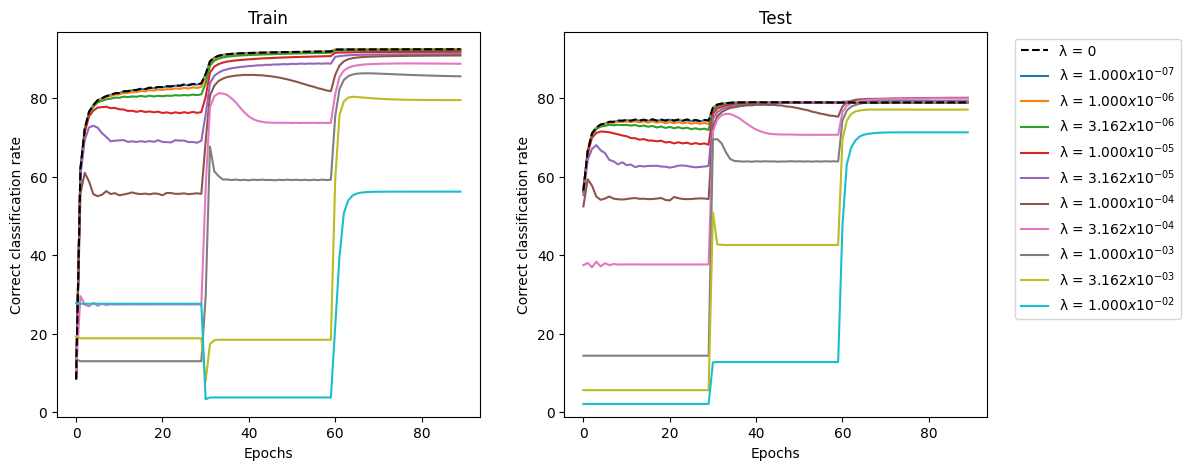

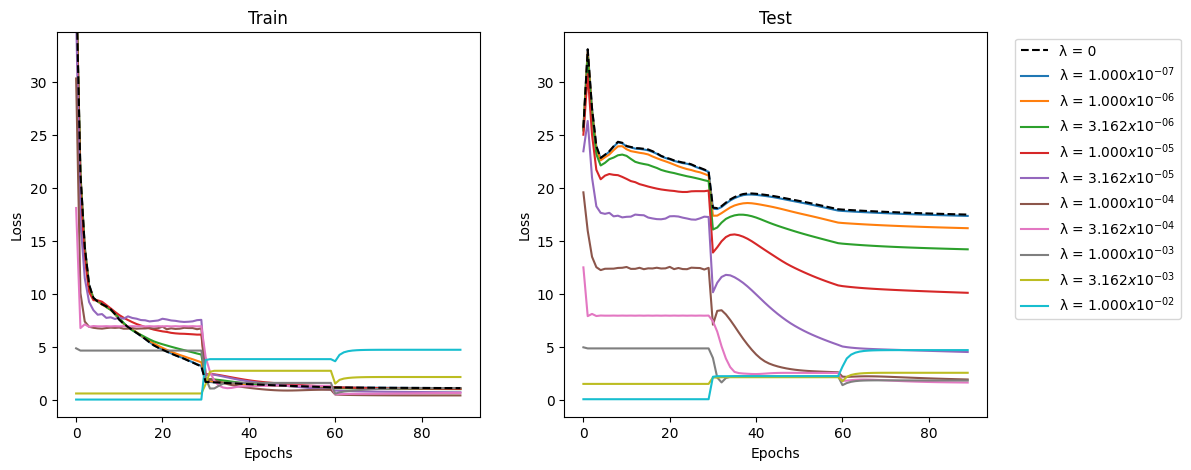

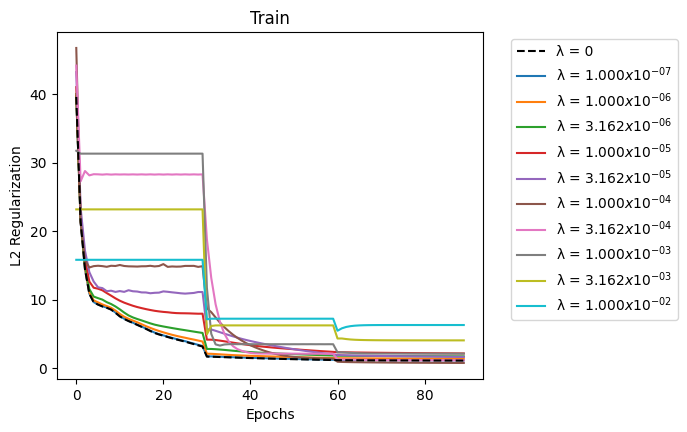

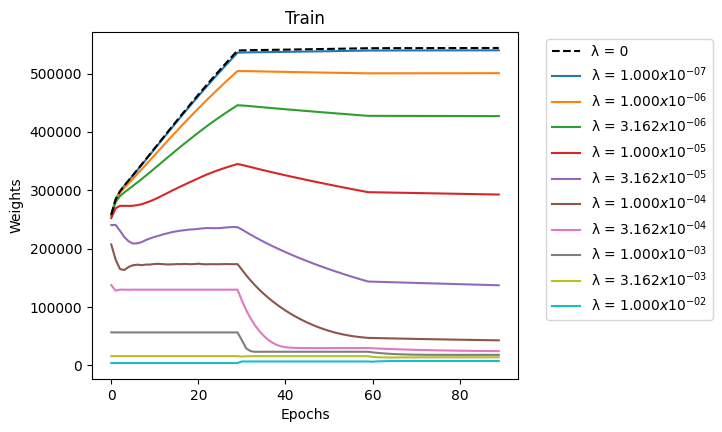

In [41]:
plot_data_per_wd(subdirectories, accuracy_test,accuracy_train, "Correct classification rate")
plot_data_per_wd(subdirectories, loss_test, loss_train,"Loss")
plot_data_per_wd_train(subdirectories, L2_reg_train, "L2 Regularization")
plot_data_per_wd_train(subdirectories, weights_train, "Weights")


#### Average value of the optimized function for each class at the 90th epoch as a function of weight decay

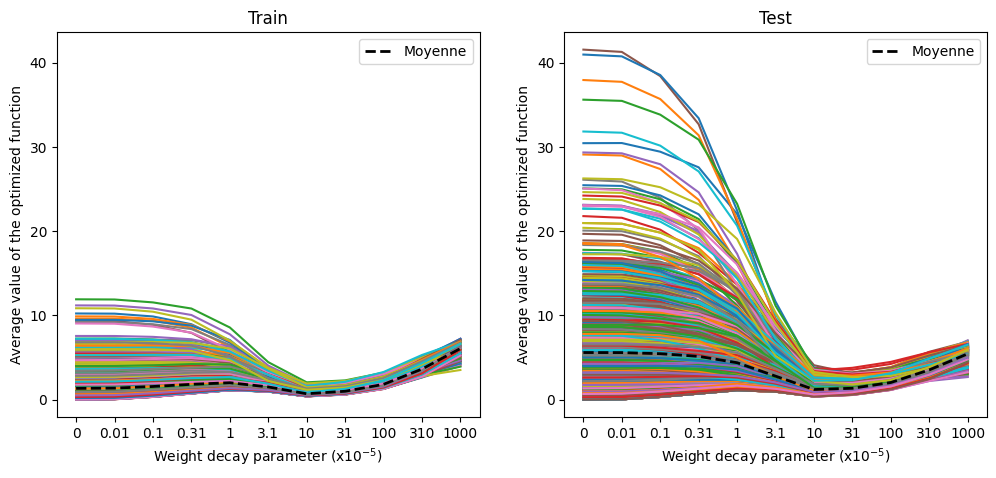

In [87]:
inte_test = torch.tensor([])
inte_train = torch.tensor([])
wd_conv = []
min_par_classe = [[],[]]
x=[]
for i in range (len(subdirectories)):
    s = round(float(subdirectories[i][-9:-6])* 10**(5-float(subdirectories[i][-2:])),3)
    if (s.is_integer()):
        wd_conv.append(int(s))
    else:
        wd_conv.append(s)
    x.append(i)

for i in mean_loss_class_test:
    inte_test = torch.cat((inte_test, i[89,:].unsqueeze(0)),dim=0)

for i in mean_loss_class_train:
    inte_train = torch.cat((inte_train, i[89,:].unsqueeze(0)),dim=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 
for index,ax in enumerate([inte_train,inte_test]):
    for i in range(1000):
        axes[index].plot(ax[:,i])
        min_par_classe[index].append(torch.argmin(ax[:,i]))
    axes[index].set_xticks(x, wd_conv)
    axes[index].plot(ax.mean(dim=1), color = 'black', linewidth ="2", linestyle="--", label = "Moyenne")
    if (index == 0):
        axes[index].set_title("Train")
    else:
        axes[index].set_title("Test")
    axes[index].set_ylabel("Average value of the optimized function")
    axes[index].set_xlabel("Weight decay parameter (x$10^{-5}$)")
    axes[index].legend()
    
#same scale
ylim1 = axes[1].get_ylim()
axes[0].set_ylim(ylim1)
plt.show()


#### Calculation of the average value of the optimized function for each group of weight decay parameter (contains classes with the same minimum value of $\lambda$) 

In [142]:
colors = sns.color_palette(n_colors=len(wd_conv))
min_erreur_classe_wd_i_train = [[] for i in range(len(subdirectories))]
min_erreur_classe_wd_i_test = [[] for i in range(len(subdirectories))]

moy_wd_i_train = [torch.tensor([0.0 for j in range(len(subdirectories))]) for i in range(len(subdirectories))]
moy_wd_i_test = [torch.tensor([0.0 for j in range(len(subdirectories))]) for i in range(len(subdirectories))]

for i,c in enumerate(min_par_classe[0]):
    min_erreur_classe_wd_i_train[c.item()].append(i)

for i,c in enumerate(min_par_classe[1]):
    min_erreur_classe_wd_i_test[c.item()].append(i)
    

for i in range(len(subdirectories)):
    for j in range(len(subdirectories)):
        moy_wd_i_train[i][j] = torch.mean(mean_loss_class_train[j][89,min_erreur_classe_wd_i_train[i]]).item()
        moy_wd_i_test[i][j] = torch.mean(mean_loss_class_test[j][89,min_erreur_classe_wd_i_test[i]]).item()


#### Find the minimum weight decay parameter : $\lambda$ for each class and see the distribution

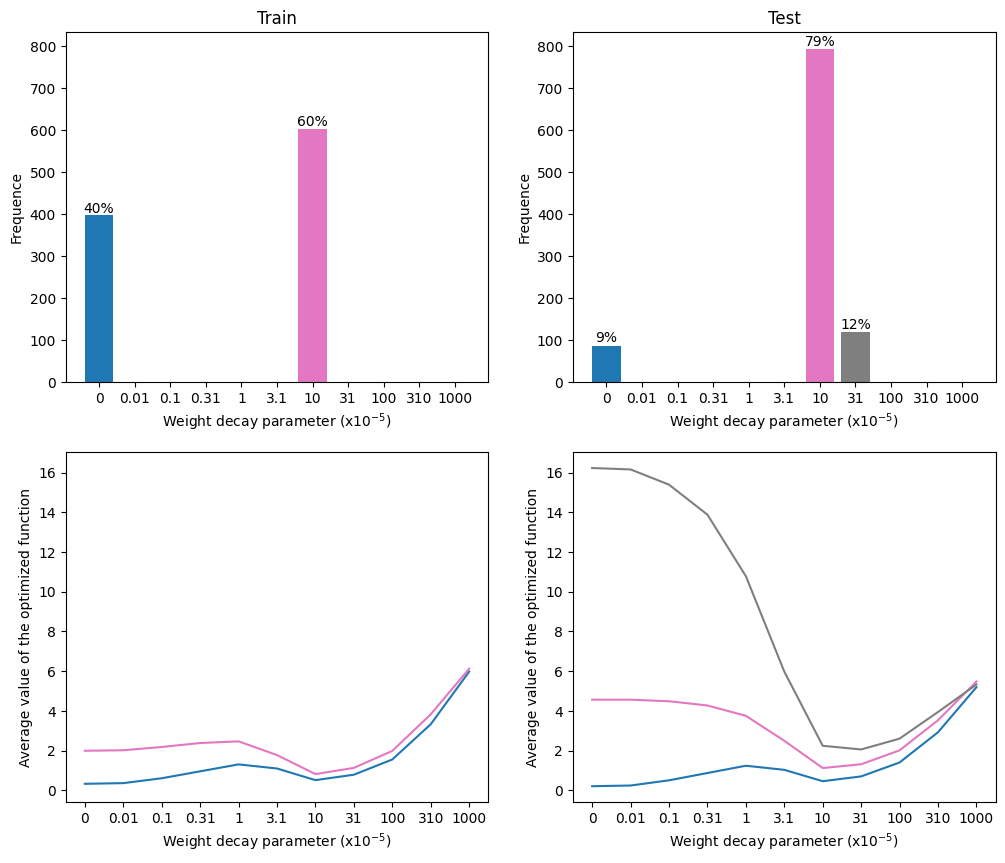

In [179]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
wd_conv_text = [f"{i}" for i in wd_conv]

count = [[0 for i in range(len(wd_conv))], [0 for i in range(len(wd_conv))]]

for i in range(2):
    for e in min_par_classe[i]:
        count[i][e.item()] += 1

    bars = axes[0,i].bar(wd_conv_text, count[i], color = colors)
    axes[0, i].set_xlabel("Weight decay parameter (x$10^{-5}$)")
    axes[0, i].set_ylabel("Frequence")
    if (i == 0):
        axes[0, i].set_title("Train")
    else:
        axes[0, i].set_title("Test")


total = [sum(count[0]),sum(count[1])]

for index in range(2):
    for i, value in enumerate(count[index]):
        if value != 0:
            percentage = value / total[index] * 100
            axes[0,index].text(i, value + 0.01 * max(count[index]), f'{percentage:.0f}%', ha="center")


#same scale
ylim1 = axes[0,1].get_ylim()
axes[0,0].set_ylim(ylim1)

for index in range(2):
    for i in range(len(wd_conv)):
        axes[1, index].set_xlabel("Weight decay parameter (x$10^{-5}$)")
        axes[1, index].set_ylabel("Average value of the optimized function")
        axes[1, index].set_xticks(x, wd_conv)
        if (index == 0):
            axes[1,index].plot(moy_wd_i_train[i],color=colors[i],label=f"Group average of λ = {subdirectories[i][-9:-4]}" + "$x10^{" + "{}".format(subdirectories[i][-3:]) +"}$")
        else:
            axes[1,index].plot(moy_wd_i_test[i],color=colors[i],label=f"Group average of λ = {subdirectories[i][-9:-4]}" + "$x10^{" + "{}".format(subdirectories[i][-3:]) +"}$")

#same scale
ylim1 = axes[1,1].get_ylim()
axes[1,0].set_ylim(ylim1)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### Draw the confusion matrix

In [167]:
last_outputs = torch.load(f'{models_folder}/last_ouputs_per_wd.pt', map_location='cpu')
dataset_test = PenultimateOutputsDataset("../data/saved_outputs/test")

for i in range(last_outputs.shape[0]):
    cf_matrix = confusion_matrix(dataset_test.labels, last_outputs[i].argmax(dim=1))
    plt.figure()
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None])
    sn.heatmap(df_cm)

ValueError: Found input variables with inconsistent numbers of samples: [50000, 10000]